Otherpay is an interesting category. It doesn't qualify as overtime pay, but it can be SUBSTANTIAL, often dwarfing the basepay. It would be interesting to see who is more likely to exceed their BasePay using OtherPay. Let's see if we can build a model to predict what employees will receive significantly large contributions to their salaries from OtherPay!

<a href='#load'>Loading and splitting data</a>
<p></p>
<a href='#visualize'>Visualizing data</a>
<p></p>
<a href='#consolidate'>Consolidating data</a>
<p></p>
<a href='#sklearn'>Modeling and training our data</a>

<a id='load'></a>

## Loading and splitting data

In [348]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [349]:
try:
    import cPickle as pickle
except:
    import pickle

In [350]:
unpickle= open('sfSalaryClean.save','rb')
workspace= pickle.load(unpickle)
workspace

['dataClean', 'clean2012', 'train2012', 'test2012']

In [351]:
objects= []
for i in range(0,len(workspace)):
    objects.append(pickle.load(unpickle))
len(objects)

4

In [360]:
#For this dataset, the only variable that I'm interested in loading is clean2012 since it has our cleaned up data 
clean2012= objects[1]

In [361]:
from sklearn.cross_validation import train_test_split
train2012, test2012 = train_test_split(clean2012, test_size = 0.2)
train2012.tail(2)

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,TitleLen
42575,Police Officer 3,117171.17,3441.09,5956.57,34574.40,126568.83,161143.23,15
49683,"Marriage, Family & Child Cnslr",84744.25,0.00,0.00,35837.64,84744.25,120581.89,29


<a id='visualize'></a>

## Visualizing our data

To begin with, let's try looking at the relationship between OtherPay and the numerical features that are <strong>NOT</strong> sums of any of the other features (eg. TotalPay and TotalPayBenefits). 

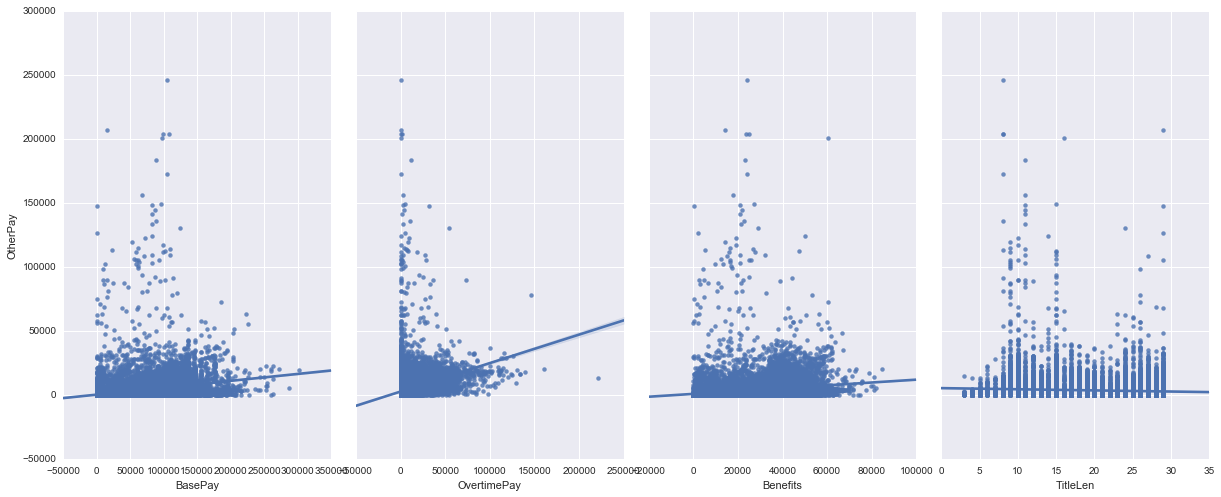

In [364]:
%matplotlib inline
sns.pairplot(train2012, 
             x_vars= ['BasePay','OvertimePay','Benefits','TitleLen'], 
             y_vars= 'OtherPay', size= 7, aspect= 0.6, 
             kind= 'reg')

In [365]:
train2012[['BasePay','OvertimePay','Benefits','TitleLen','OtherPay']].corr()#Correlation matrix for variables possibly related to OtherPay

,BasePay,OvertimePay,Benefits,TitleLen,OtherPay
BasePay,1.000000,0.278480,0.911432,-0.010701,0.285105
OvertimePay,0.278480,1.000000,0.273539,-0.021716,0.322436
Benefits,0.911432,0.273539,1.000000,0.014473,0.219517
TitleLen,-0.010701,-0.021716,0.014473,1.000000,-0.072185
OtherPay,0.285105,0.322436,0.219517,-0.072185,1.000000


Our plots are quite noisy, but do show some weak <strong>linear relationships</strong> between the features and the response. It is also clear that there is a subset of employees that are making more money from OtherPay than from what should be the largest contributor to their salary, BasePay (left panel). The correlation matrix validates that aside from BasePay and Benefits, most features only have a weak to moderate correlation with one another. 

<a id='consolidate'></a>

## Consolidating  data

Now let's see if we can find the employees with OtherPays that are approximately (> 90% of BasePay) as large as their BasePay (1 if True, 0 if False) and make this dummy variable our new <strong>categorical response</strong>.


In [375]:
basePayTrain= np.array(train2012['BasePay'])#Turn Series into list to speed up our for loop
otherPayTrain= np.array(train2012['OtherPay'])
excess= []; exValue= [];#Excess= otherPay > 0.9*basePay, equals 1 or 0; exValue= OtherPay quantity
for i in range(0,len(basePayTrain)):
    
    if 0.9*basePayTrain[i] <= otherPayTrain[i]:#Choosing OtherPay values greater than 90% of BasePay
        excess.append(1)
    else:
        excess.append(0)
exValue= np.array(excess)*otherPayTrain#Masking OtherPay with results from excess

<IPython.core.display.Javascript object>


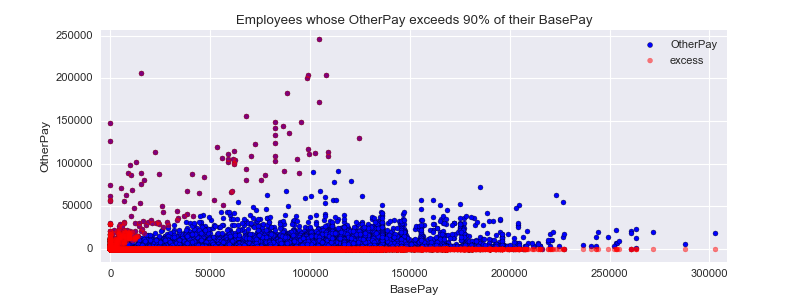

There are 559 employees who make approximately as much from from "OtherPay" as from their "BasePay".
The sum of their "OtherPay" wages is $ 11090444.61


In [406]:
#Let's see what portion of the employees for into the 'excess' category on our BasePay vs OtherPay plot
%matplotlib nbagg
legOtherPay= plt.scatter(basePayTrain,train2012['OtherPay'])
legExvalue= plt.scatter(basePayTrain,exValue, color= 'red', alpha= 0.5, label= 'excess')#Masked out OtherPay appears as zero on plot
plt.xlabel('BasePay'); plt.ylabel('OtherPay'); plt.legend(handles=[legOtherPay, legExvalue])
plt.title('Employees whose OtherPay exceeds 90% of their BasePay')
print 'There are', sum(excess), 'employees who make approximately as much from from "OtherPay" as from their "BasePay".'
print 'The sum of their "OtherPay" wages is $', sum(exValue)

To put that into context, SF spent <a href='http://www.nytimes.com/2016/02/05/us/super-bowl-50-further-divides-san-francisco.html?_r=0'>$5 million</a> on putting the Superbowl together in 2016.

In [377]:
#Now let's add the results from excess to our dataframe as 'ThreshPay'
train2012['ThreshPay']= excess
train2012.tail()

c:\Users\D\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,TitleLen,ThreshPay
40948,Police Officer 3,117162.62,12685.03,7557.15,34744.78,137404.80,172149.58,15,0
60997,Custodian,45740.74,1947.86,2924.91,26790.83,50613.51,77404.34,8,0
71481,Special Nurse,1815.60,0.00,46.54,519.04,1862.14,2381.18,12,0
42575,Police Officer 3,117171.17,3441.09,5956.57,34574.40,126568.83,161143.23,15,0
49683,"Marriage, Family & Child Cnslr",84744.25,0.00,0.00,35837.64,84744.25,120581.89,29,0


Finally, we'll do the same for our testing dataset. Once this is finished we can train and test our model!

In [378]:
basePayTest= np.array(test2012['BasePay'])#Turn Series into list to speed up our for loop
otherPayTest= np.array(test2012['OtherPay'])
excessTest= []; exValueTest= [];#Excess= 1 or 0; exValue= OtherPay quantity
for i in range(0,len(basePayTest)):
    
    if 0.9*basePayTest[i] <= otherPayTest[i]:#Choosing OtherPay values greater than 90% of BasePay
        excessTest.append(1)
    else:
        excessTest.append(0)
exValueTest= np.array(excessTest)*otherPayTest#Masking OtherPay with results from excess
test2012['ThreshPay']= excessTest#Adding list as a column to test2012 testing dataset

c:\Users\D\Anaconda\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<a id='sklearn'></a>

## Modeling and training our data

Now that we have consolidated our responses into 'ThreshPay' and added it to our dataset, we can make and train our model, and finally use it to make predictions on the test dataset. Let's begin by organizing our features and responses (x and y, respectively) into new dataframes for both the training and testing sets.

In [382]:
xTrain2012= train2012[['BasePay','OvertimePay','Benefits','TitleLen']]
yTrain2012= train2012[['ThreshPay']]

xTest2012= test2012[['BasePay','OvertimePay','Benefits','TitleLen']]
yTest2012= test2012[['ThreshPay']]

In [388]:
xTrain2012.tail(1)#Checking that we have the appropriate features

,BasePay,OvertimePay,Benefits,TitleLen
49683,84744.25,0,35837.64,29


Since our feature set, xTrain2012, is relatively small, and we saw some linear relationships between our features and OtherPay, let's assume we can model our relationship with a linear model, using logistic regression and random forests, and <strong>with and without</strong> TitleLen (our weakest correlation coefficient).

In [465]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

#Initialize model objects for all four situations
linmod= LogisticRegression()#Include all four features
linmod2= LogisticRegression()#All features but TitleLen
forest= RandomForestClassifier(n_estimators= 100)#Include all four features
forest2= RandomForestClassifier(n_estimators= 100)#All features but TitleLen

In [488]:
xTrain2012.head(1)

,BasePay,OvertimePay,Benefits,TitleLen
45532,64812.03,37105.66,38593.37,15


In [490]:
#Train the models 
linfit= linmod.fit(xTrain2012,yTrain2012)
linfit2= linmod2.fit(xTrain2012[['BasePay','OvertimePay','Benefits']],yTrain2012)
forfit= forest.fit(xTrain2012,yTrain2012)
forfit2= forest2.fit(xTrain2012[['BasePay','OvertimePay','Benefits']],yTrain2012)

c:\Users\D\Anaconda\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\D\Anaconda\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\D\Anaconda\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
c:\Users\D\Anaconda\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [491]:
#Make predictions using the test datasets
# linpred= linfit.predict(xTest2012)
# linpred2= linfit2.predict(xTest2012[['BasePay','OvertimePay','Benefits']])
forpred= forfit.predict(xTest2012)
forpred2= forfit2.predict(xTest2012[['BasePay','OvertimePay','Benefits']])

ValueError: Number of features of the model must  match the input. Model n_features is 3 and  input n_features is 4 

In [435]:
cmLin= confusion_matrix(yTest2012,outputLin)

133 0


In [ ]:
print zip(yTest2012['ThreshPay'],outputLin)#Hmm come back to this

In [306]:
from sklearn.ensemble import RandomForestClassifier
forest= RandomForestClassifier(n_estimators= 100)

In [308]:
forest= forest.fit(xTrain2012,yTrain2012)

c:\Users\D\Anaconda\lib\site-packages\ipykernel\__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


In [436]:
#Linear model without TitleLen as a feature
linmod2= LogisticRegression()
linmod2= linmod2.fit(xTrain2012[['BasePay','OvertimePay','Benefits']],yTrain2012)
outputLin2= linmod2.predict(xTest2012[['BasePay','OvertimePay','Benefits']])
accuracy_score(yTest2012,outputLin2)

c:\Users\D\Anaconda\lib\site-packages\sklearn\utils\validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.99197715528963826

In [447]:
print zip(yTest2012['ThreshPay'], output2)

[(0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),

In [439]:
forest2= RandomForestClassifier(n_estimators= 100)
forest2= forest.fit(xTrain2012[['BasePay','OvertimePay','Benefits']],yTrain2012['ThreshPay'])

In [448]:
output2= forest2.predict(xTest2012[['BasePay','OvertimePay','Benefits']])
print sum(yTest2012['ThreshPay']), sum(output2)
accuracy_score(yTest2012,output2)

133 104


0.99415284199075338

In [444]:
print zip(yTest2012['ThreshPay'],output2)#Oh cool, this one works much better! :D

[(0, 0), (0, 0), (0, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0),

In [445]:
accuracy_score(yTest2012,output2)

0.99415284199075338

<IPython.core.display.Javascript object>


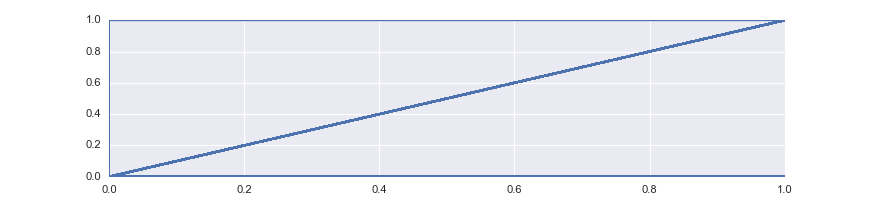

In [329]:
pair= zip(output,yTest2012['ThreshPay'])
print sum(output), sum(yTest2012['ThreshPay'])

115 132


In [453]:
from sklearn.metrics import confusion_matrix
cmForest2= confusion_matrix(yTest2012,output2)

In [455]:
cmFor2Norm = cmForest2.astype('float') / cmForest2.sum(axis=1)[:, np.newaxis]

In [456]:
cmFor2Norm

array([[  9.99030605e-01,   9.69394821e-04],
       [  2.70676692e-01,   7.29323308e-01]])

<IPython.core.display.Javascript object>


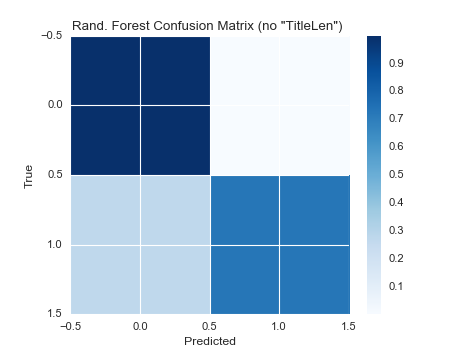

In [464]:
plt.subplot(1,3,1)
plt.imshow(cmFor2Norm, interpolation='nearest', cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.colorbar()
plt.title('Rand. Forest Confusion Matrix (no "TitleLen") ')

plt.subplot(1,3,2)
plt.imshow(cmFor2Norm, interpolation='nearest', cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.colorbar()
plt.title('Rand. Forest Confusion Matrix (no "TitleLen") ')


plt.subplot(1,3,3)
plt.imshow(cmFor2Norm, interpolation='nearest', cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.colorbar()
plt.title('Rand. Forest Confusion Matrix (no "TitleLen") ')